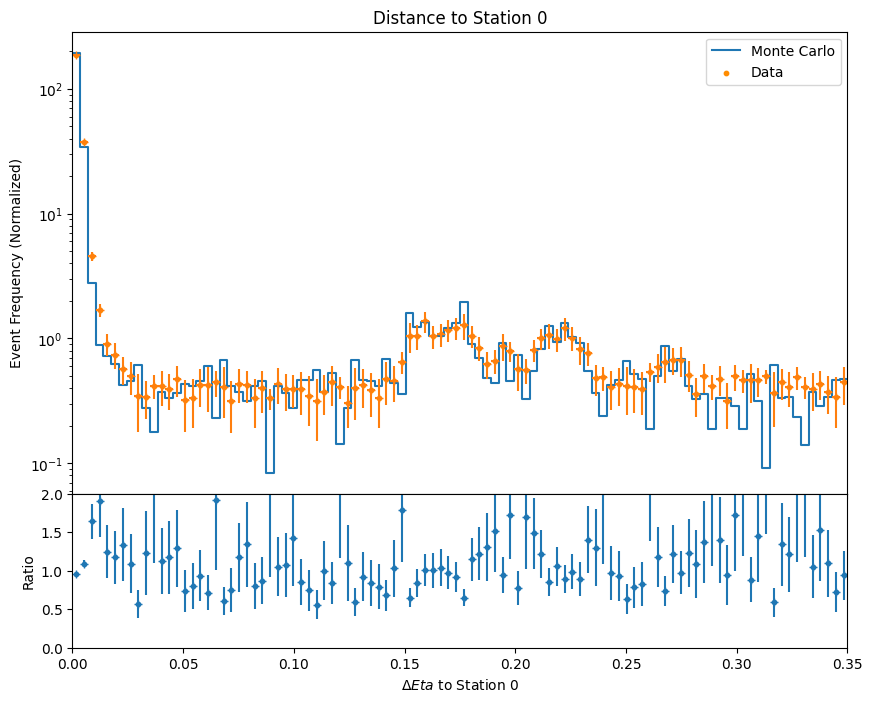

C:\Users\scien\AppData\Local\Programs\Python\Python311\Lib\site-packages\awkward\_backends\backend.py:47: RuntimeWarning: divide by zero encountered in divide
  return getattr(ufunc, method)(*args, **kwargs)


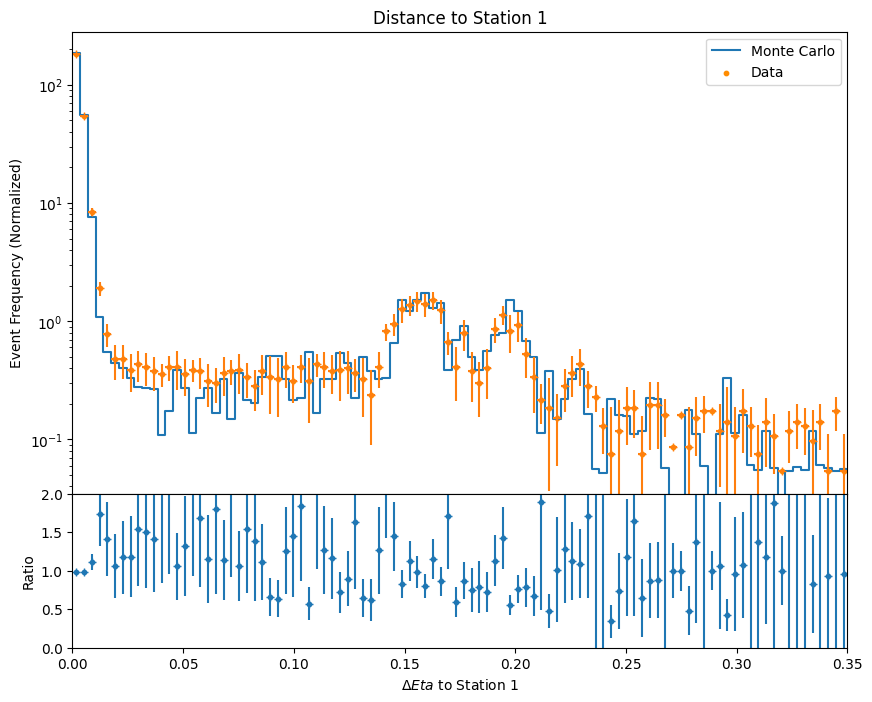

C:\Users\scien\AppData\Local\Programs\Python\Python311\Lib\site-packages\awkward\_backends\backend.py:47: RuntimeWarning: divide by zero encountered in divide
  return getattr(ufunc, method)(*args, **kwargs)


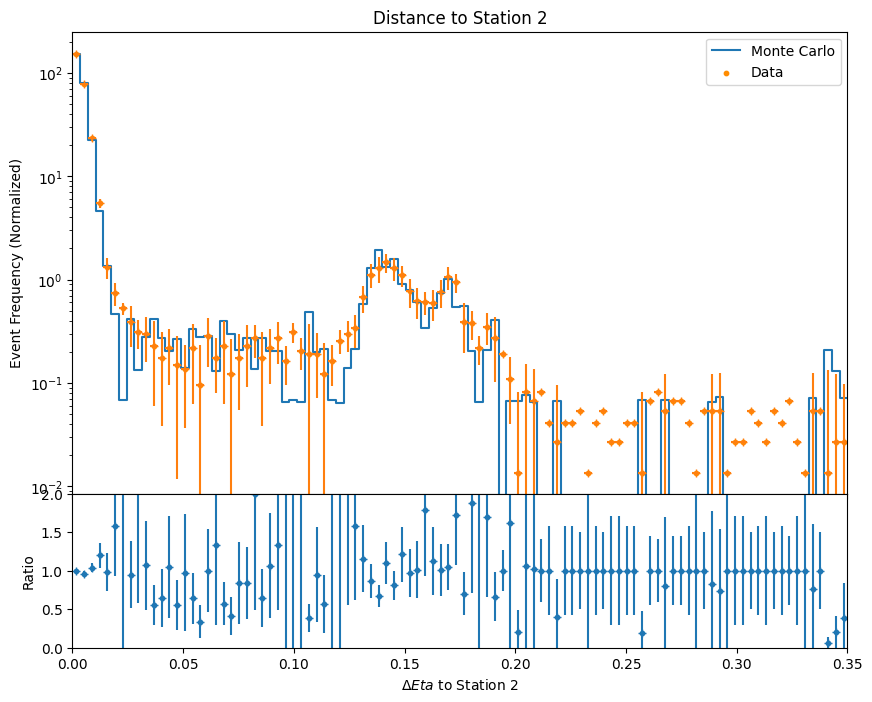

C:\Users\scien\AppData\Local\Programs\Python\Python311\Lib\site-packages\awkward\_backends\backend.py:47: RuntimeWarning: divide by zero encountered in divide
  return getattr(ufunc, method)(*args, **kwargs)


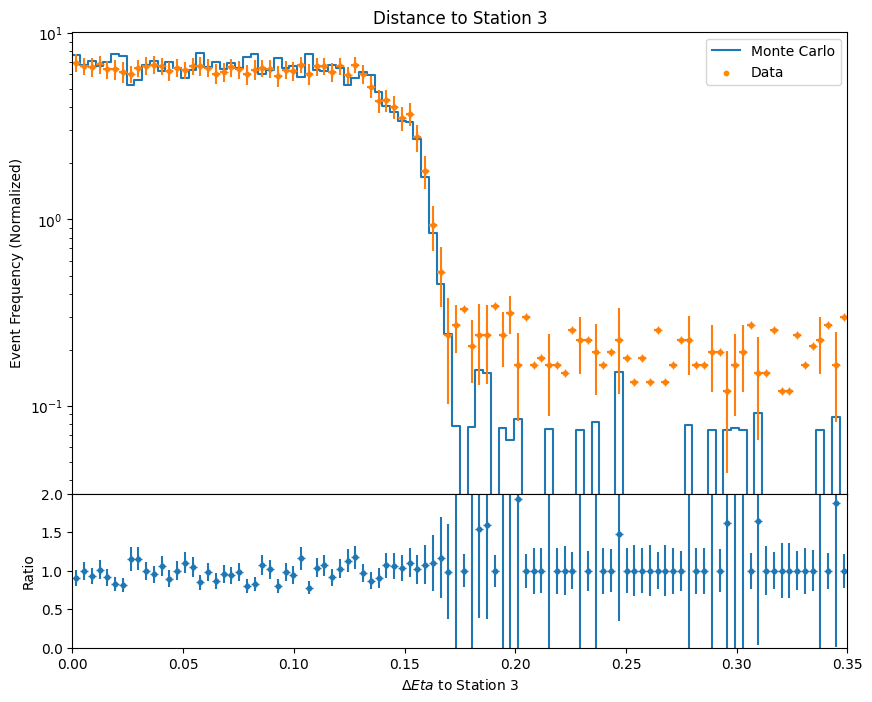

   dtDEtabyStation_0  dtDEtabyStation_1  dtDEtabyStation_2  dtDEtabyStation_3  \
0          -1.000000          -1.000000          -1.000000          -1.000000   
1          -0.002969          -1.072509          -1.000000          -1.000000   
2           0.000941          -0.000075          -0.002278          -0.049180   
3          -0.000421          -0.002020          -0.145223          -1.000000   
4           0.005445          -1.000000          -1.000000           0.696527   
5          -0.002120           0.248552          -1.000000          -1.000000   
6          -1.000000          -1.000000          -1.000000          -1.000000   
7           0.000210           0.001195           0.003374           0.132002   
8          -1.000000          -1.000000          -1.000000          -1.000000   
9          -1.197820           2.129628          -1.000000          -1.000000   

   dtDPhibyStation_0  dtDPhibyStation_1  dtDPhibyStation_2  dtDPhibyStation_3  \
0          -1.000000       

In [1]:
import uproot
import awkward as ak
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math


class Type:
    def __init__(self, name):
        self.name = name
        self.sameSignFile = uproot.open('highHcal_'+str(self.name)+'_tagAligned (2).root')
        self.sameSignEvents = self.sameSignFile['demo']['allEvents']['sigVariables']
        self.branches = self.sameSignEvents.arrays()
        self.eta = self.branches['eta']
        self.phi = self.branches['phi']
        self.EventWeight = self.branches['EventWeight']
        self.DEta_S = []
        for i in range (4):
            self.DEta_S.append(self.branches['dtDEtabyStation_' + str(i)])
        self.DPhi_S = []
        for i in range (4):
            self.DPhi_S.append(self.branches['dtDPhibyStation_' + str(i)])

Data = Type('data')
MC = Type('mc')

#Data.sameSignFile.keys()
#Data.sameSignEvents
#Data.sameSignEvents.keys()
#Data.branches['pt']

#Coord refers to eta, phi, or Delta Eta (DEta)
class Coord:
    def __init__(self,name,x1,x2,bins):
        self.name = name
        self.x1 = x1
        self.x2 = x2
        self.bins = np.linspace(x1, x2, bins+1)  # creates an array of bin edges
        self.bin_width = (x2 - x1) / bins


# Initialize class to help calculate normalized histograms for any data set
class NormalizedHist:
    def __init__(self, data, view_bins, bin_width):
        self.data = data[0]
        self.view_bins = view_bins
        self.bin_width = bin_width
        self.norm_factor = 1 / (np.sum(self.data) * self.bin_width)      # normalization factor
        self.temp = (data[1] + self.bin_width / 2)                       # offset bin edge values by + 1/2 bin
        self.bin_centers = self.temp[:-1]                                # cut last value to give bin center
        self.freq = self.data * self.norm_factor                         # normalized frequency
        self.err = (self.data ** 0.5) * self.norm_factor                 # normalized vertical error bar


#---------------------------------------------------------------------------------------------------------------------------------------

DEta = Coord('DEta',0,0.35,100)   # set Delta Eta edges/bin

# Use pandas to make an array of values ordered by event ID
features = ['dtDEtabyStation_0', 'dtDEtabyStation_1', 'dtDEtabyStation_2', 'dtDEtabyStation_3', 'dtDPhibyStation_0', 'dtDPhibyStation_1', 'dtDPhibyStation_2', 'dtDPhibyStation_3', 'EventWeight']
mcEvents = MC.sameSignEvents.arrays(features, library='pd')

features = ['dtDEtabyStation_0', 'dtDEtabyStation_1', 'dtDEtabyStation_2', 'dtDEtabyStation_3', 'dtDPhibyStation_0', 'dtDPhibyStation_1', 'dtDPhibyStation_2', 'dtDPhibyStation_3']
dataEvents = Data.sameSignEvents.arrays(features, library='pd')

for i in range(4):
    bin_indices = np.zeros_like(MC.DEta_S[i].to_numpy())         # Array for storing bin indices
    for j, deltaR in enumerate(MC.DEta_S[i]):                    # [(0, Delta_Eta), (1, Delta_Eta) ...] <--- list(enumerate(")) should give this
        bin_indices[j] = np.digitize(deltaR, DEta.bins) - 1      # returns bin index for each Delta Eta
        mcEvents['Bin_Station_'+str(i)] = bin_indices          # Add new column with bin indices
#print(mcEvents[:5])

ratio_station = []
ratio_freq = []               # this will make sense later, keep scrolling

applied_Ratio = []
#---------------------------------------------------------------------------------------------------------------------------------------

# Method for plotting histograms
def plot_hist_eta(DEta, i, x1, x2): 
   
    
    # Create numpy histogram data for Data & MC so ratio can be calculated by initializing each as NormalizedHist Class
    data_hist = NormalizedHist(np.histogram(Data.DEta_S[i], bins=DEta.bins, range=(DEta.x1, DEta.x2), density=None), len(DEta.bins), DEta.bin_width)
    mc_hist = NormalizedHist(np.histogram(MC.DEta_S[i], bins=DEta.bins, range=(DEta.x1, DEta.x2), density=None, weights=MC.EventWeight), len(DEta.bins), DEta.bin_width)
    
    ratio_freq = np.divide(data_hist.freq, mc_hist.freq)
    ratio_freq = [1 if math.isinf(x) else x for x in ratio_freq] # goodify the infinities
    ratio_err = ratio_freq * np.sqrt((data_hist.err / (data_hist.freq + 1e-10))**2 + (mc_hist.err / (mc_hist.freq + 1e-10))**2) 
    # calculate ratio error -> propagation of uncertainty

    # save ratio_freq per station for later
    applied_Ratio.append(ratio_freq)
    
    # Loop over events, assign bin ratio to each event
    ratio_station.append(np.zeros_like(MC.DEta_S[i].to_numpy()))             # create empty array similar to DEta for station[j]
    for k, deltaR in enumerate(MC.DEta_S[i]):                                # [(0, Delta_Eta), (1, Delta_Eta) ...] <--- list(enumerate(")) should give this
        bin_index = np.digitize(deltaR, DEta.bins) - 1                       # returns bin index for each Delta Eta
        if bin_index >= len(ratio_freq):                                   # check if index is out of bound
            bin_index = len(ratio_freq) - 1                                # assign the last valid index
        ratio_station[i][k] = ratio_freq[bin_index]                        # find item j in array and change it to the ratio_freq of that bin index

    assert len(mcEvents) == len(ratio_station[i])            # make sure length matches
    mcEvents['Ratio_Station_'+str(i)] = ratio_station[i]     # add new column

    #PLOT----------------------------------------------------------------------------------------------------------------------------------

    # Adjusting axs[0].step from bin edge to bin center results in loss of first bar because it is shifted 1/2 bin width; this adds that point back at 0
    step_bc = mc_hist.bin_centers+DEta.bin_width/2
    step_f = mc_hist.freq
    step_bc.to_numpy
    step_f.to_numpy
    step_bin_centers = np.insert(step_bc, 0, 0.0)
    step_freq = np.insert(step_f, 0, mc_hist.freq[0])

    # Set up histogram, use bars for MC
    
    fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0, 'height_ratios': [3, 1]}, figsize=(10, 8))
    axs[0].step(step_bin_centers, step_freq, label='Monte Carlo') 
    axs[0].set_title('Distance to Station '+str(i))
    axs[0].set_ylabel('Event Frequency (Normalized)')
    axs[0].set_yscale('log')
    
    # Scatter data by attribute
    axs[0].scatter(data_hist.bin_centers, data_hist.freq, s=10, color='darkorange', label='Data')
    axs[0].errorbar(data_hist.bin_centers, data_hist.freq, xerr=DEta.bin_width/2, yerr=mc_hist.err, fmt='+')
    axs[0].set_xlim(x1, x2)
    axs[0].legend()

    # Scatter ratio plot
    axs[1].scatter(data_hist.bin_centers, ratio_freq, s=10)
    axs[1].errorbar(data_hist.bin_centers, ratio_freq, yerr=ratio_err, fmt='+')
    axs[1].set_ylim(0,2)
    axs[1].set_ylabel('Ratio')
    axs[1].set_xlabel('$\Delta Eta$ to Station '+str(i))
    
    plt.show()

    return mc_hist, data_hist

    #-------------------------------------------------------------------------------------------------------------------------------------
    
# Do the thing
for i in range (4):
    plot_hist_eta(DEta, i, 0, 0.35)

print(mcEvents[:10])

C:\Users\scien\AppData\Local\Programs\Python\Python311\Lib\site-packages\awkward\_backends\backend.py:47: RuntimeWarning: divide by zero encountered in divide
  return getattr(ufunc, method)(*args, **kwargs)


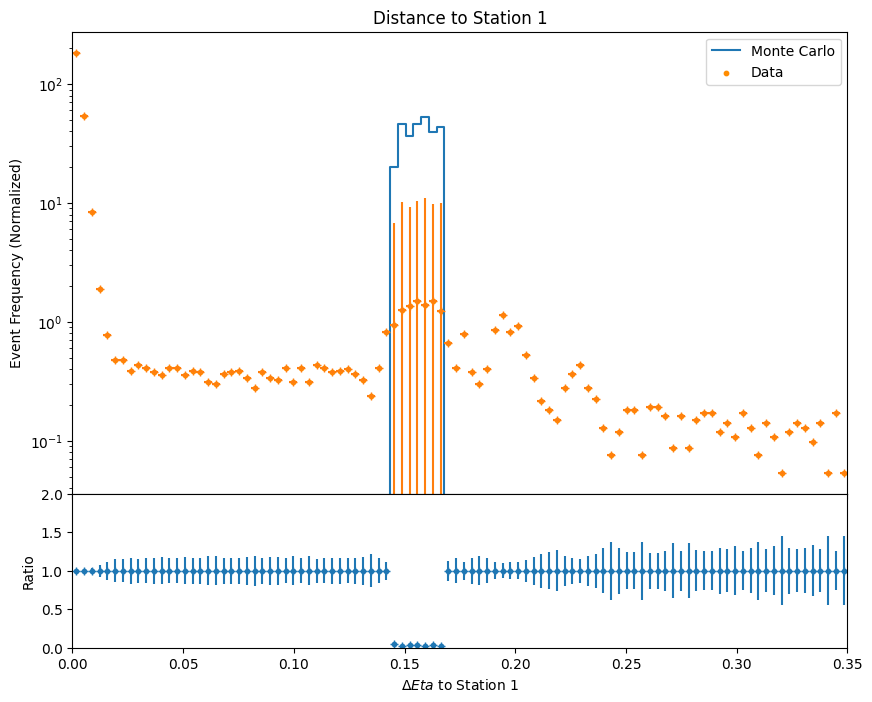

(<__main__.NormalizedHist at 0x205c5a7a6d0>,
 <__main__.NormalizedHist at 0x205b94b8110>)

In [2]:
second_eta_peak = mcEvents.loc[(mcEvents['Bin_Station_1']*DEta.bin_width >= 0.14) & (abs(mcEvents['Bin_Station_1']*DEta.bin_width) <= 0.165)]
filtered_eta = second_eta_peak['dtDEtabyStation_1'].to_numpy()
filtered_weight = second_eta_peak['EventWeight'].to_numpy()

def plot_hist_eta(DEta, i, x1, x2): 
   
    # Create numpy histogram data for Data & MC so ratio can be calculated by initializing each as NormalizedHist Class
    data_hist = NormalizedHist(np.histogram(Data.DEta_S[i], bins=DEta.bins, range=(DEta.x1, DEta.x2), density=None), len(DEta.bins), DEta.bin_width)
    mc_hist = NormalizedHist(np.histogram(filtered_eta, bins=DEta.bins, range=(DEta.x1, DEta.x2), density=None, weights=filtered_weight), len(DEta.bins), DEta.bin_width)

    ratio_freq = np.divide(data_hist.freq, mc_hist.freq)
    ratio_freq = [1 if math.isinf(x) else x for x in ratio_freq] # goodify the infinities
    ratio_err = ratio_freq * np.sqrt((data_hist.err / (data_hist.freq + 1e-10))**2 + (mc_hist.err / (mc_hist.freq + 1e-10))**2) 
    # calculate ratio error -> propagation of uncertainty

    # save ratio_freq per station for later
    applied_Ratio.append(ratio_freq)
    
    # Loop over events, assign bin ratio to each event
    ratio_station.append(np.zeros_like(filtered_eta))             # create empty array similar to DEta for station[j]
    for k, deltaR in enumerate(filtered_eta):                                # [(0, Delta_Eta), (1, Delta_Eta) ...] <--- list(enumerate(")) should give this
        bin_index = np.digitize(deltaR, DEta.bins) - 1                       # returns bin index for each Delta Eta
        if bin_index >= len(ratio_freq):                                   # check if index is out of bound
            bin_index = len(ratio_freq) - 1                                # assign the last valid index
        ratio_station[i][k] = ratio_freq[bin_index]                        # find item j in array and change it to the ratio_freq of that bin index

    assert len(mcEvents) == len(ratio_station[i])            # make sure length matches
    mcEvents['Ratio_Station_'+str(i)] = ratio_station[i]     # add new column

    #PLOT----------------------------------------------------------------------------------------------------------------------------------

    # Adjusting axs[0].step from bin edge to bin center results in loss of first bar because it is shifted 1/2 bin width; this adds that point back at 0
    step_bc = mc_hist.bin_centers+DEta.bin_width/2
    step_f = mc_hist.freq
    step_bc
    step_f
    step_bin_centers = np.insert(step_bc, 0, 0.0)
    step_freq = np.insert(step_f, 0, mc_hist.freq[0])

    # Set up histogram, use bars for MC
    
    fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0, 'height_ratios': [3, 1]}, figsize=(10, 8))
    axs[0].step(step_bin_centers, step_freq, label='Monte Carlo') 
    axs[0].set_title('Distance to Station '+str(i))
    axs[0].set_ylabel('Event Frequency (Normalized)')
    axs[0].set_yscale('log')
    
    # Scatter data by attribute
    axs[0].scatter(data_hist.bin_centers, data_hist.freq, s=10, color='darkorange', label='Data')
    axs[0].errorbar(data_hist.bin_centers, data_hist.freq, xerr=DEta.bin_width/2, yerr=mc_hist.err, fmt='+')
    axs[0].set_xlim(x1, x2)
    axs[0].legend()

    # Scatter ratio plot
    axs[1].scatter(data_hist.bin_centers, ratio_freq, s=10)
    axs[1].errorbar(data_hist.bin_centers, ratio_freq, yerr=ratio_err, fmt='+')
    axs[1].set_ylim(0,2)
    axs[1].set_ylabel('Ratio')
    axs[1].set_xlabel('$\Delta Eta$ to Station '+str(i))
    
    plt.show()

    return mc_hist, data_hist

    #-------------------------------------------------------------------------------------------------------------------------------------
    
# Do the thing
plot_hist_eta(DEta, 1, 0, 0.35)

C:\Users\scien\AppData\Local\Temp\ipykernel_19556\2211972228.py:13: RuntimeWarning: divide by zero encountered in divide
  ratio_freq = np.divide(data_hist.freq, mc_hist.freq)
C:\Users\scien\AppData\Local\Temp\ipykernel_19556\2211972228.py:13: RuntimeWarning: invalid value encountered in divide
  ratio_freq = np.divide(data_hist.freq, mc_hist.freq)


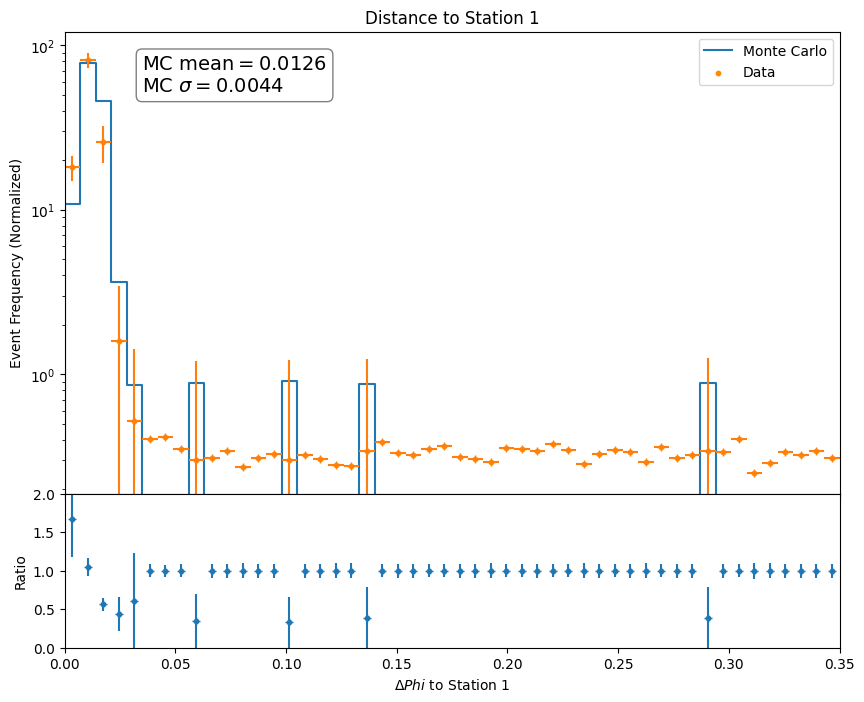

(<__main__.NormalizedHist at 0x205c5768e10>,
 <__main__.NormalizedHist at 0x205ab6ff5d0>)

In [3]:
DPhi = Coord('DPhi',-0.35,0.35,100)   # set Delta Eta edges/bin
filtered_phi = [abs(values) for values in second_eta_peak['dtDPhibyStation_1'].to_numpy()]


def plot_hist_phi(DPhi, i, x1, x2): 

    Data.DPhi_S[i] = [abs(values) for values in Data.DPhi_S[i]]
   
    # Create numpy histogram data for Data & MC so ratio can be calculated by initializing each as NormalizedHist Class
    data_hist = NormalizedHist(np.histogram(Data.DPhi_S[i], bins=DPhi.bins, range=(DPhi.x1, DPhi.x2), density=None), len(DPhi.bins), DPhi.bin_width)
    mc_hist = NormalizedHist(np.histogram(filtered_phi, bins=DPhi.bins, range=(DPhi.x1, DPhi.x2), density=None, weights=filtered_weight), len(DPhi.bins), DPhi.bin_width)

    ratio_freq = np.divide(data_hist.freq, mc_hist.freq)
    ratio_freq = [1 if math.isinf(x) else x for x in ratio_freq] # goodify the infinities
    ratio_err = ratio_freq * np.sqrt((data_hist.err / (data_hist.freq + 1e-10))**2 + (mc_hist.err / (mc_hist.freq + 1e-10))**2) 
    # calculate ratio error -> propagation of uncertainty

    # save ratio_freq per station for later
    applied_Ratio.append(ratio_freq)
    
    # Loop over events, assign bin ratio to each event
    ratio_station.append(np.zeros_like(filtered_phi))             # create empty array similar to DPhi for station[j]
    for k, deltaR in enumerate(filtered_phi):                                # [(0, Delta_Phi), (1, Delta_Phi) ...] <--- list(enumerate(")) should give this
        bin_index = np.digitize(deltaR, DPhi.bins) - 1                       # returns bin index for each Delta Phi
        if bin_index >= len(ratio_freq):                                   # check if index is out of bound
            bin_index = len(ratio_freq) - 1                                # assign the last valid index
        ratio_station[i][k] = ratio_freq[bin_index]                        # find item j in array and change it to the ratio_freq of that bin index

    assert len(mcEvents) == len(ratio_station[i])            # make sure length matches
    mcEvents['Ratio_Station_'+str(i)] = ratio_station[i]     # add new column

    #PLOT----------------------------------------------------------------------------------------------------------------------------------

    # Adjusting axs[0].step from bin edge to bin center results in loss of first bar because it is shifted 1/2 bin width; this adds that point back at 0
    step_bc = mc_hist.bin_centers+DPhi.bin_width/2
    step_f = mc_hist.freq
    step_bc
    step_f
    step_bin_centers = np.insert(step_bc, 0, 0.0)
    step_freq = np.insert(step_f, 0, mc_hist.freq[0])

    # Set up histogram, use bars for MC
    
    fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0, 'height_ratios': [3, 1]}, figsize=(10, 8))
    axs[0].step(step_bin_centers, step_freq, label='Monte Carlo') 
    axs[0].set_title('Distance to Station '+str(i))
    axs[0].set_ylabel('Event Frequency (Normalized)')
    axs[0].set_yscale('log')

    filtered_peak = [values for values in filtered_phi if values < 0.05]
    # Show mean and std for MC
    textstr = '\n'.join((
    r'$\mathrm{MC \ mean}=%.4f$' % (np.mean(filtered_peak), ),
    r'$\mathrm{MC \ }\sigma=%.4f$' % (np.std(filtered_peak), )))
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    axs[0].text(0.10, 0.95, textstr, transform=axs[0].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
    
    # Scatter data by attribute
    axs[0].scatter(data_hist.bin_centers, data_hist.freq, s=10, color='darkorange', label='Data')
    axs[0].errorbar(data_hist.bin_centers, data_hist.freq, xerr=DPhi.bin_width/2, yerr=mc_hist.err, fmt='+')
    axs[0].set_xlim(x1, x2)
    axs[0].legend()

    # Scatter ratio plot
    axs[1].scatter(data_hist.bin_centers, ratio_freq, s=10)
    axs[1].errorbar(data_hist.bin_centers, ratio_freq, yerr=ratio_err, fmt='+')
    axs[1].set_ylim(0,2)
    axs[1].set_ylabel('Ratio')
    axs[1].set_xlabel('$\Delta Phi$ to Station '+str(i))
    
    plt.show()

    return mc_hist, data_hist

    #-------------------------------------------------------------------------------------------------------------------------------------
    
# Do the thing
plot_hist_phi(DPhi, 1, 0, 0.35)

C:\Users\scien\AppData\Local\Programs\Python\Python311\Lib\site-packages\awkward\_backends\backend.py:47: RuntimeWarning: invalid value encountered in divide
  return getattr(ufunc, method)(*args, **kwargs)


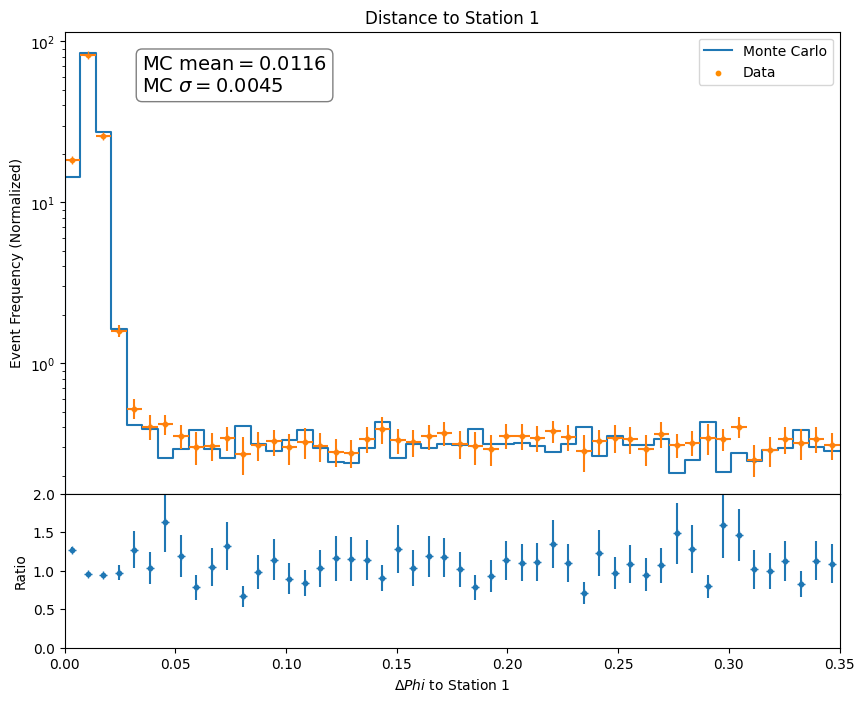

(<__main__.NormalizedHist at 0x205d4ee8110>,
 <__main__.NormalizedHist at 0x205d4e23250>)

In [4]:
def plot_hist_phi(DPhi, i, x1, x2): 

    MC.DPhi_S[i] = [abs(values) for values in MC.DPhi_S[i]]
    
    # Create numpy histogram data for Data & MC so ratio can be calculated by initializing each as NormalizedHist Class
    data_hist = NormalizedHist(np.histogram(Data.DPhi_S[i], bins=DPhi.bins, range=(DPhi.x1, DPhi.x2), density=None), len(DPhi.bins), DPhi.bin_width)
    mc_hist = NormalizedHist(np.histogram(MC.DPhi_S[i], bins=DPhi.bins, range=(DPhi.x1, DPhi.x2), density=None, weights=MC.EventWeight), len(DPhi.bins), DPhi.bin_width)
    
    ratio_freq = np.divide(data_hist.freq, mc_hist.freq)
    ratio_freq = [1 if math.isinf(x) else x for x in ratio_freq] # goodify the infinities
    ratio_err = ratio_freq * np.sqrt((data_hist.err / (data_hist.freq + 1e-10))**2 + (mc_hist.err / (mc_hist.freq + 1e-10))**2) 
    # calculate ratio error -> propagation of uncertainty

    # save ratio_freq per station for later
    applied_Ratio.append(ratio_freq)
    
    # Loop over events, assign bin ratio to each event
    ratio_station.append(np.zeros_like(MC.DPhi_S[i]))             # create empty array similar to DPhi for station[j]
    for k, deltaR in enumerate(MC.DPhi_S[i]):                                # [(0, Delta_Phi), (1, Delta_Phi) ...] <--- list(enumerate(")) should give this
        bin_index = np.digitize(deltaR, DPhi.bins) - 1                       # returns bin index for each Delta Phi
        if bin_index >= len(ratio_freq):                                   # check if index is out of bound
            bin_index = len(ratio_freq) - 1                                # assign the last valid index
        ratio_station[i][k] = ratio_freq[bin_index]                        # find item j in array and change it to the ratio_freq of that bin index

    assert len(mcEvents) == len(ratio_station[i])            # make sure length matches
    mcEvents['Ratio_Station_'+str(i)] = ratio_station[i]     # add new column

    #PLOT----------------------------------------------------------------------------------------------------------------------------------

    # Adjusting axs[0].step from bin edge to bin center results in loss of first bar because it is shifted 1/2 bin width; this adds that point back at 0
    step_bc = mc_hist.bin_centers+DPhi.bin_width/2
    step_f = mc_hist.freq
    step_bc.to_numpy
    step_f.to_numpy
    step_bin_centers = np.insert(step_bc, 0, 0.0)
    step_freq = np.insert(step_f, 0, mc_hist.freq[0])

    # Set up histogram, use bars for MC
    
    fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0, 'height_ratios': [3, 1]}, figsize=(10, 8))
    axs[0].step(step_bin_centers, step_freq, label='Monte Carlo') 
    axs[0].set_title('Distance to Station '+str(i))
    axs[0].set_ylabel('Event Frequency (Normalized)')
    axs[0].set_yscale('log')
    
    # Scatter data by attribute
    axs[0].scatter(data_hist.bin_centers, data_hist.freq, s=10, color='darkorange', label='Data')
    axs[0].errorbar(data_hist.bin_centers, data_hist.freq, xerr=DPhi.bin_width/2, yerr=mc_hist.err, fmt='+')
    axs[0].set_xlim(x1, x2)
    axs[0].legend()

    filtered_peak = [values for values in MC.DPhi_S[i] if values < 0.05]
    # Show mean and std for MC
    textstr = '\n'.join((
    r'$\mathrm{MC \ mean}=%.4f$' % (np.mean(filtered_peak), ),
    r'$\mathrm{MC \ }\sigma=%.4f$' % (np.std(filtered_peak), )))
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    axs[0].text(0.10, 0.95, textstr, transform=axs[0].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

    # Scatter ratio plot
    axs[1].scatter(data_hist.bin_centers, ratio_freq, s=10)
    axs[1].errorbar(data_hist.bin_centers, ratio_freq, yerr=ratio_err, fmt='+')
    axs[1].set_ylim(0,2)
    axs[1].set_ylabel('Ratio')
    axs[1].set_xlabel('$\Delta Phi$ to Station '+str(i))
    
    plt.show()

    return mc_hist, data_hist

    #-------------------------------------------------------------------------------------------------------------------------------------
    
# Do the thing
plot_hist_phi(DPhi, 1, 0, 0.35)